# **Binary Classification** - [`Sklearn make_moons` dataset]

## Preparing the DataSet

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


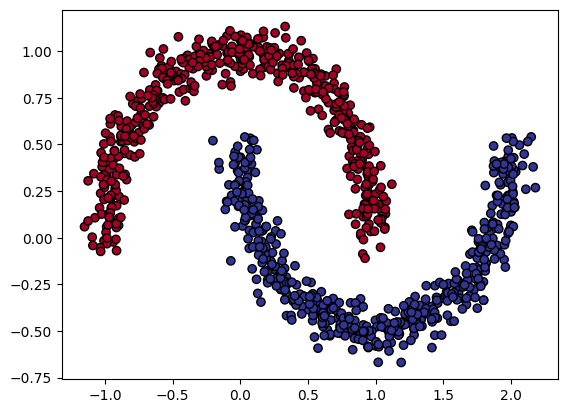

In [1]:
import pandas as pd                      # Importing pandas for data manipulation
import matplotlib.pyplot as plt          # Importing matplotlib for plotting
from sklearn.datasets import make_moons  # Importing make_moons dataset from scikit-learn

# Constants
NUM_SAMPLES = 1000  # Number of samples to generate
RANDOM_SEED = 42    # Seed for reproducibility

# Generate moon-shaped data
X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

# Create a DataFrame to hold the data
moon_df = pd.DataFrame({"X0": X[:, 0],  # Feature X0
                        "X1": X[:, 1],  # Feature X1
                        "y": y})        # Target variable y

# Display the first few rows of the DataFrame
display(moon_df.head())

# Plotting the moon-shaped data
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.scatter(moon_df.X0, moon_df.X1, c=y, cmap=plt.cm.RdYlBu, edgecolors="black")
plt.show()

## Build a model by subclassing `nn.Module`

In [2]:
import torch

# Turn data into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Spliting the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [3]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class MoonModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = MoonModel(in_features=2,
                  out_features=1,
                  hidden_units=10).to(device)

print("Model's: ", next(model.parameters()))
print("Model's device: ", next(model.parameters()).device)
print(model)
print(model.state_dict().keys())

cpu
Model's:  Parameter containing:
tensor([[-0.3225, -0.3946],
        [-0.4373,  0.1675],
        [-0.1625, -0.3755],
        [ 0.1326,  0.5201],
        [ 0.2552,  0.1982],
        [-0.0912, -0.5479],
        [ 0.3449,  0.0743],
        [-0.1896,  0.3994],
        [-0.6606,  0.1059],
        [-0.4293,  0.5156]], requires_grad=True)
Model's device:  cpu
MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)
odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'])


**Different ways of defining the forward pass**

```python
def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x
```

```python
def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out
```

```python
def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
```


## Setup a binary classification compatible **loss function**, **optimizer** and **accuracy**

In [4]:
loss_fn = nn.BCEWithLogitsLoss()                       # sigmoid layer built-in

# loss_fn = nn.BCELoss() # requires sigmoid layer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of model to optimize
                            lr=0.1)                    #learning rate

In [5]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.0 MB/s eta 0:00:00


In [6]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) #send accuracy function to the devicer
acc_fn

MulticlassAccuracy()

## Getting Prediction probabilites - Untrained Model

In [7]:
y_logits = model(X_test.to(device)).squeeze()
y_pred_probs = torch.sigmoid(y_logits)  # Obtain probabilities
y_preds = torch.round(y_pred_probs)     # Round the probabilities

print(y_test[:5], y_preds[:5])
print(y_preds.shape, y_test.shape)
print(acc_fn(preds=y_preds, target=y_test.int()))

tensor([1., 0., 1., 0., 1.]) tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)
torch.Size([200]) torch.Size([200])
tensor(0.5000)


## Creating Training and Test loop

Epoch: 0 | Loss: 0.70 Acc: 50.00 | Test loss: 0.70 Test acc: 50.00
Epoch: 100 | Loss: 0.34 Acc: 83.62 | Test loss: 0.36 Test acc: 83.00
Epoch: 200 | Loss: 0.25 Acc: 88.50 | Test loss: 0.24 Test acc: 89.00
Epoch: 300 | Loss: 0.23 Acc: 89.00 | Test loss: 0.22 Test acc: 89.50
Epoch: 400 | Loss: 0.21 Acc: 90.25 | Test loss: 0.20 Test acc: 91.50
Epoch: 500 | Loss: 0.17 Acc: 92.25 | Test loss: 0.17 Test acc: 92.50
Epoch: 600 | Loss: 0.13 Acc: 94.62 | Test loss: 0.12 Test acc: 96.00
Epoch: 700 | Loss: 0.09 Acc: 97.38 | Test loss: 0.08 Test acc: 98.50
Epoch: 800 | Loss: 0.06 Acc: 99.00 | Test loss: 0.05 Test acc: 99.50
Epoch: 900 | Loss: 0.04 Acc: 99.50 | Test loss: 0.03 Test acc: 100.00




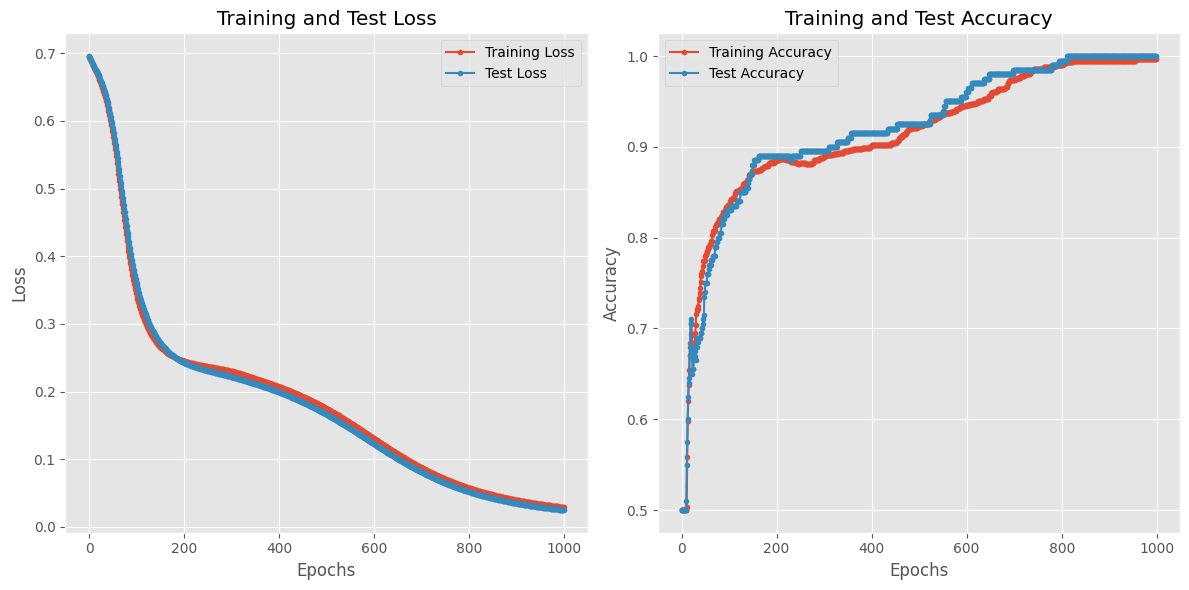

In [8]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Send the data to the device
X_train, X_test = X_train.to(device), X_test.to((device))
y_train, y_test = y_train.to(device), y_test.to((device))

# Loop Through the data
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_pred_probs)

    # 2. loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(preds=y_preds, target=y_train.int())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    # Appending train loss and accuracy to the list
    train_losses.append(loss.item())
    train_accuracies.append(acc)


    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_preds = torch.round(test_pred_probs)

        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(preds=test_preds, target=y_test.int())

        # Appending test loss and  test accuracy to the list
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

    # Training progress report/model evaluation summary
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {100*acc:.2f} | Test loss: {test_loss:.2f} Test acc: {100*test_acc:.2f}")



print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

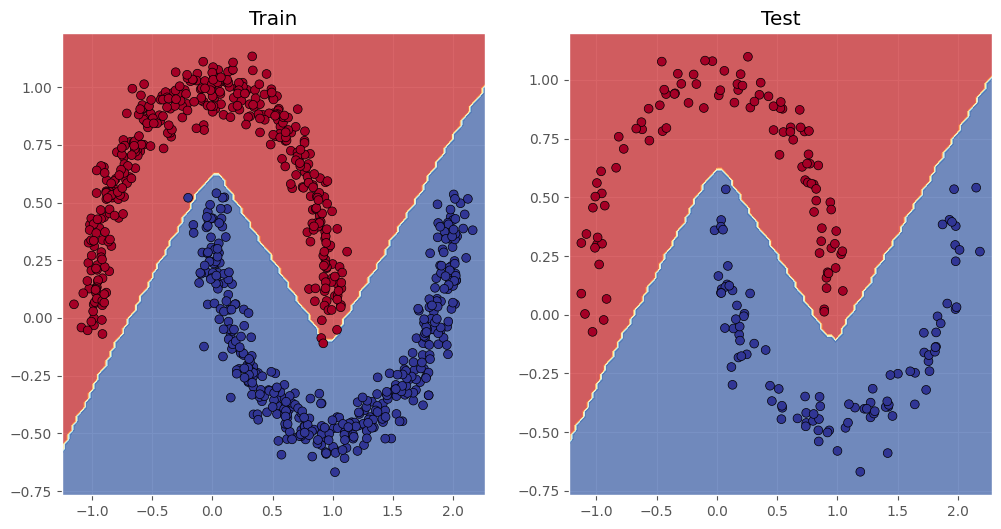

In [10]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)